In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('src/')

In [2]:
# Set a consistent style for the plots
sns.set_theme(style="whitegrid")

In [3]:
# Prefix path
PREFIX_PATH = 'data'

In [4]:
# Set to display all columns
pd.set_option('display.max_columns', None)

# Set to display 50 rows
pd.set_option('display.max_rows', 50)

# Importing the final dataset
df = pd.read_csv(f'{PREFIX_PATH}/final_data_complete.csv')

In [5]:
from utils.methods import conv_to_dict, get_list

In [6]:
temp = pd.DataFrame(list(df['distilbert_emotions'].apply(conv_to_dict)))

In [7]:
import ast
df['Genres'] = df['Genres'].apply(ast.literal_eval)

In [8]:
emotions_df = pd.concat([df, temp], axis=1)

In [9]:
emotions_df['merge_year'] = emotions_df['merge_year'].astype("Int64")

In [10]:
emotions = ['disgust', 'fear', 'anger', 'neutral', 'sadness', 'surprise', 'joy']

In [11]:
emotion_by_time = emotions_df.groupby('merge_year').agg({
    emotion: ['mean'] for emotion in emotions
})

In [12]:
emotion_by_time.columns = emotions

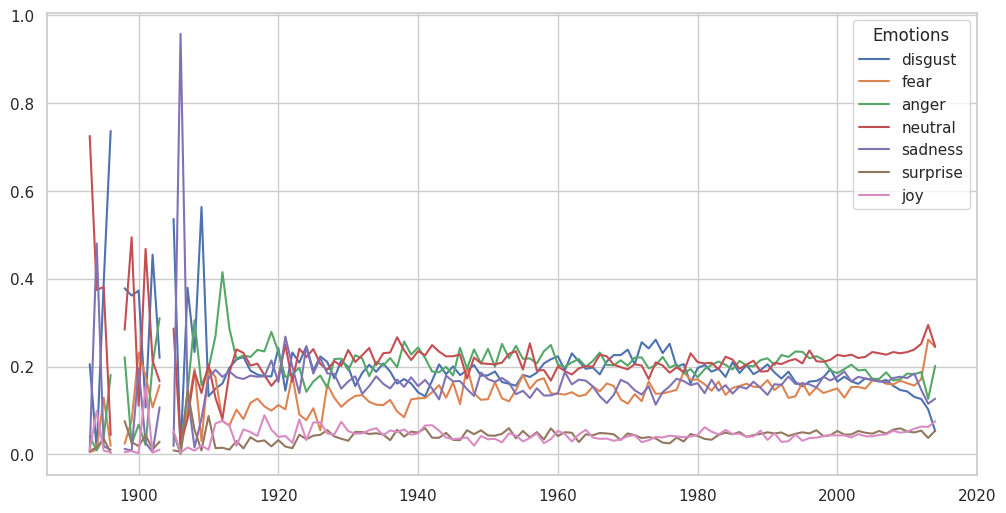

In [13]:
plt.figure(figsize=(12, 6))

for column in emotion_by_time.columns:
    plt.plot(emotion_by_time.index, emotion_by_time[column], label=column)

plt.legend(title='Emotions', loc='best')

<Axes: xlabel='merge_year', ylabel='Count'>

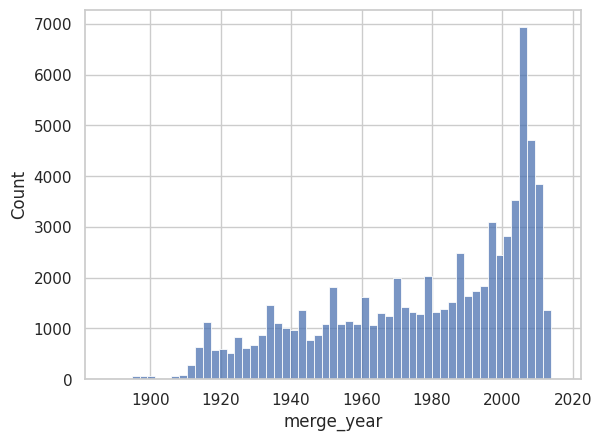

In [14]:
sns.histplot(emotions_df['merge_year'], kde=False)

In [15]:
movie_counts = emotions_df.groupby(['merge_year']).agg(
    counts=('merge_year', 'size')
)
movie_counts[movie_counts.index >= 2010]

,counts
merge_year,
2010,2024
2011,1824
2012,1195
2013,164
2014,17
2015,4
2016,3


In [16]:
emotion_by_time = emotion_by_time[(emotion_by_time.index >= 1925) & (emotion_by_time.index <= 2012)]

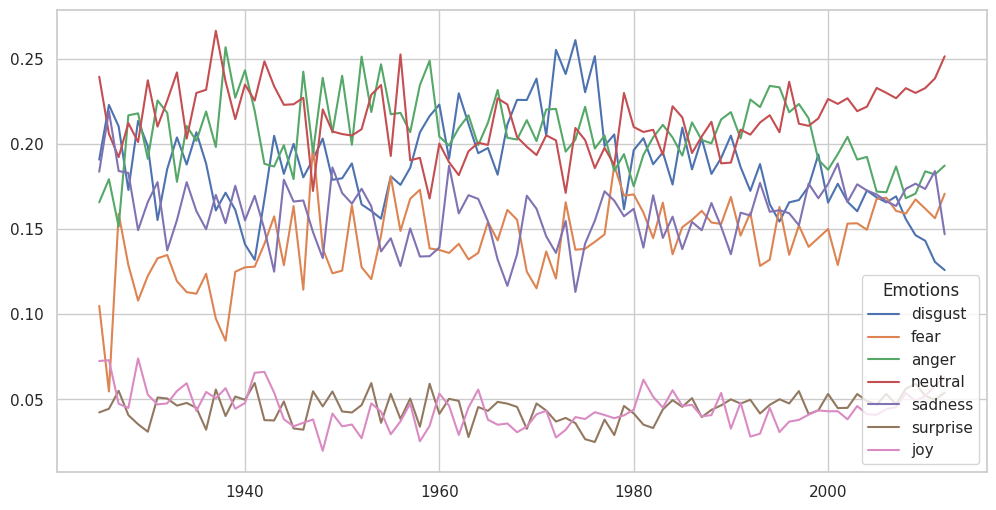

In [17]:
plt.figure(figsize=(12, 6))

for column in emotion_by_time.columns:
    plt.plot(emotion_by_time.index, emotion_by_time[column], label=column)

plt.legend(title='Emotions', loc='best')

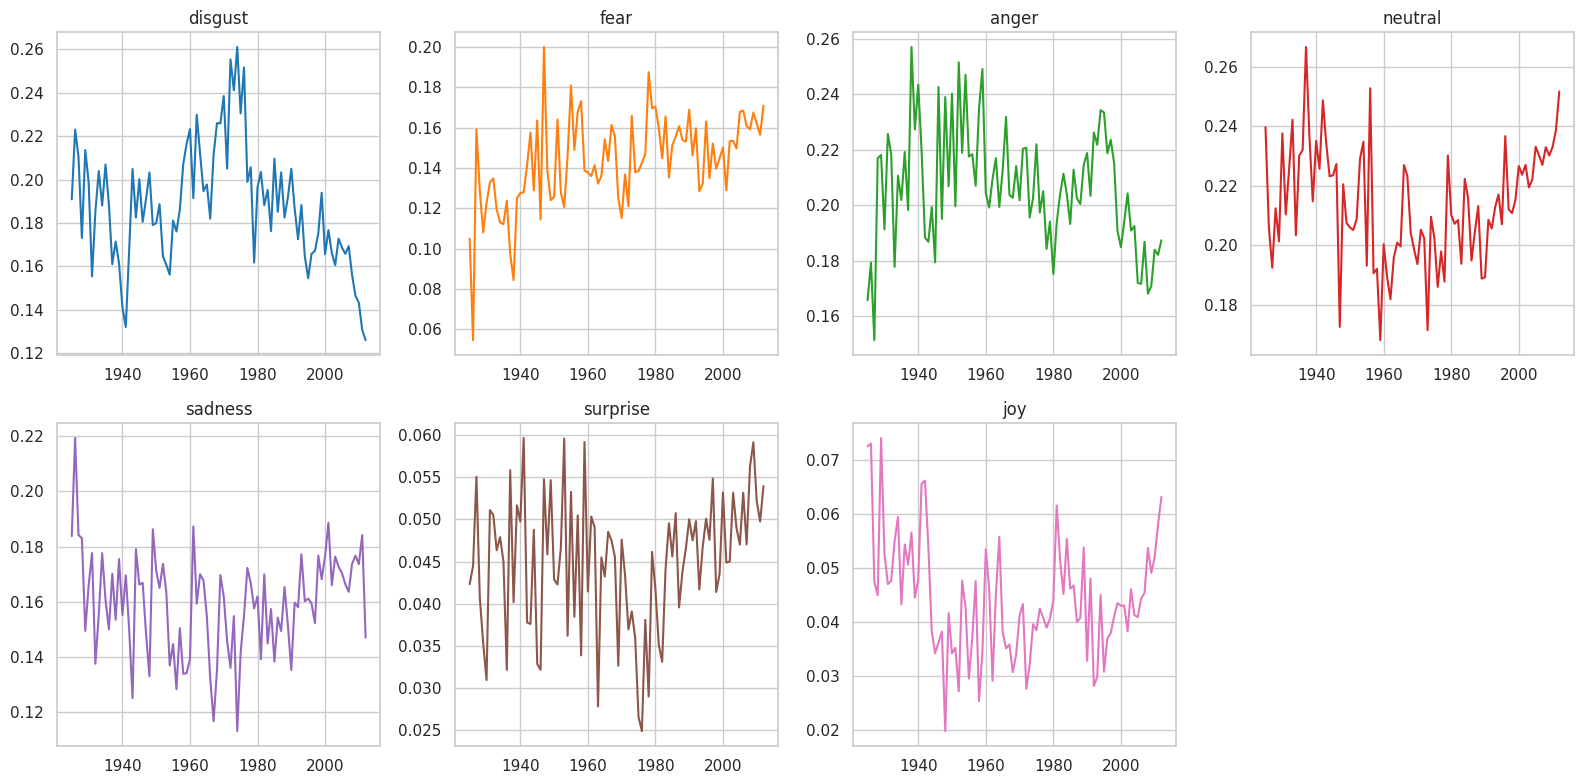

In [18]:
num_emotions = len(emotion_by_time.columns)
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()
colors = sns.color_palette("tab10", len(emotion_by_time.columns))

for ax, column, color in zip(axes, emotion_by_time.columns, colors):
    ax.plot(emotion_by_time.index, emotion_by_time[column], color=color)
    ax.set_title(column)

for ax in axes[num_emotions: ]:
    ax.axis('off')

plt.tight_layout()
plt.show()

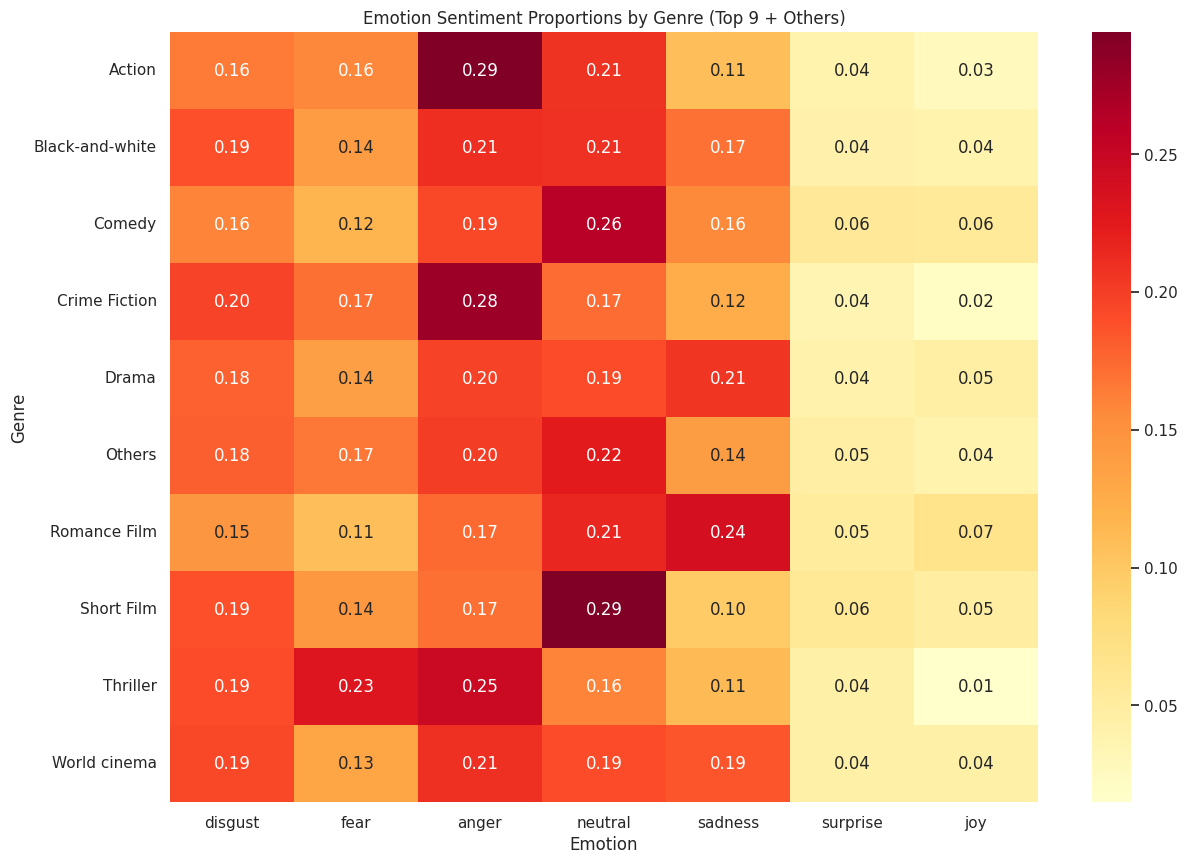

In [19]:
emotions_df = pd.DataFrame(emotions_df)

# Expand the genres into individual rows
emotions_df_expanded = emotions_df.explode('Genres')

# Count the frequency of each genre
genre_counts = emotions_df_expanded['Genres'].value_counts()

# Get the top 9 genres based on the frequency
top_genres = genre_counts.nlargest(9).index

# Calculate the mean emotion for each genre
emotion_data = emotions_df_expanded.groupby('Genres')[['disgust', 'fear', 'anger', 'neutral', 'sadness', 'surprise', 'joy']].mean()

# Group all other genres into 'Others'
emotion_data['Genre'] = emotion_data.index
emotion_data.loc[~emotion_data['Genre'].isin(top_genres), 'Genre'] = 'Others'

# Aggregate the 'Others' genres and recalculate proportions
emotion_data_grouped = emotion_data.groupby('Genre').sum()
emotion_data_grouped = emotion_data_grouped.div(emotion_data_grouped.sum(axis=1), axis=0)

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(emotion_data_grouped, annot=True, fmt='.2f', cbar=True, cmap='YlOrRd')
plt.title('Emotion Sentiment Proportions by Genre (Top 9 + Others)')
plt.ylabel('Genre')
plt.xlabel('Emotion')
plt.show()

In [20]:
from statsmodels.multivariate.manova import MANOVA

In [21]:
emotion_data['Genre'] = emotion_data['Genre'].astype('category')

In [27]:
emotion_data

,disgust,fear,anger,neutral,sadness,surprise,joy,Genre
Genres,,,,,,,,
Absurdism,0.158321,0.160077,0.192030,0.295986,0.110683,0.031679,0.051225,Others
Acid western,0.312701,0.073484,0.447390,0.101810,0.054188,0.006797,0.003630,Others
Action,0.164581,0.157858,0.294362,0.207060,0.109015,0.039658,0.027467,Action
Action Comedy,0.140269,0.120686,0.316956,0.237830,0.112674,0.045198,0.026388,Others
Action Thrillers,0.166711,0.178508,0.346742,0.178739,0.084897,0.034386,0.010017,Others
...,...,...,...,...,...,...,...,...
World History,0.339566,0.234933,0.035120,0.349791,0.020231,0.016512,0.003846,Others
World cinema,0.193272,0.131769,0.209227,0.191067,0.185803,0.044350,0.044512,World cinema
Wuxia,0.168100,0.112803,0.363971,0.197278,0.114601,0.027093,0.016153,Others


In [24]:
emotions.remove('neutral')

In [25]:
manova = MANOVA.from_formula(f'{ " + ".join(emotions) } ~ Genre', data=emotion_data)

In [26]:
print(manova.mv_test())

                   Multivariate linear model
                                                               
---------------------------------------------------------------
         Intercept        Value  Num DF  Den DF  F Value Pr > F
---------------------------------------------------------------
            Wilks' lambda 0.8154 6.0000 340.0000 12.8319 0.0000
           Pillai's trace 0.1846 6.0000 340.0000 12.8319 0.0000
   Hotelling-Lawley trace 0.2264 6.0000 340.0000 12.8319 0.0000
      Roy's greatest root 0.2264 6.0000 340.0000 12.8319 0.0000
---------------------------------------------------------------
                                                               
---------------------------------------------------------------
         Genre          Value   Num DF   Den DF  F Value Pr > F
---------------------------------------------------------------
          Wilks' lambda 0.9815 54.0000 1738.2608  0.1184 1.0000
         Pillai's trace 0.0187 54.0000 2070.0000  0.1195 1.